In [18]:

# import tensorflow as tf
# tf.config.list_physical_devices('GPU')

# tf.test.is_gpu_available()

In [19]:
# !pip install tensorflow_hub

In [20]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
from keras.applications import resnet
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import  EfficientNetB5, EfficientNetB7
from keras.models import Model
from keras.layers import Dense,Flatten,Conv2D,MaxPool2D,Dropout,BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
import matplotlib.pyplot as plt

In [21]:
print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.10.0
Hub version: 0.15.0
GPU is available


In [22]:
# input path for the images
data_dir = 'vehicle-dataset/'
ds_name = 'Vechiles'

In [23]:
def generate_data_paths(data_dir):
    
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        
        if fold == 'Van':
            continue
            
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
            
    return filepaths, labels


filepaths, labels = generate_data_paths(data_dir)

In [24]:
def create_df(filepaths, labels):

    Fseries = pd.Series(filepaths, name= 'filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis= 1)
    return df

df = create_df(filepaths, labels)

In [25]:
df.head()

,filepaths,labels
0,vehicle-dataset/Bicycle\bicycle (1).jpg,Bicycle
1,vehicle-dataset/Bicycle\bicycle (10).jpg,Bicycle
2,vehicle-dataset/Bicycle\bicycle (100).jpg,Bicycle
3,vehicle-dataset/Bicycle\bicycle (101).jpg,Bicycle
4,vehicle-dataset/Bicycle\bicycle (102).jpg,Bicycle


In [26]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123)

In [27]:
def num_of_classes(df, name='df'):
    print(f"The {name} dataset has {len(df['labels'].unique())} classes")
    
num_of_classes(df, ds_name)

The Vechiles dataset has 15 classes


In [28]:
num_of_classes(train_df, "Training "+ds_name)
num_of_classes(valid_df, "Validation "+ds_name)
num_of_classes(test_df, "Testing "+ds_name)

The Training Vechiles dataset has 15 classes
The Validation Vechiles dataset has 15 classes
The Testing Vechiles dataset has 15 classes


In [29]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.4,0.6],
                           zoom_range=0.3,
                           horizontal_flip=True,
                           vertical_flip=True)

ts_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=40,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.4,0.6],
                           zoom_range=0.3,
                           horizontal_flip=True,
                           vertical_flip=True)

train_gen = tr_gen.flow_from_dataframe(train_df, 
                                       x_col= 'filepaths', 
                                       y_col= 'labels', 
                                       target_size= img_size, 
                                       class_mode= 'categorical',
                                       color_mode= 'rgb', 
                                       shuffle= True, 
                                       batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, 
                                       x_col= 'filepaths', 
                                       y_col= 'labels', 
                                       target_size= img_size, 
                                       class_mode= 'categorical',
                                       color_mode= 'rgb', 
                                       shuffle= True, 
                                       batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe(test_df, 
                                      x_col= 'filepaths', 
                                      y_col= 'labels', 
                                      target_size= img_size, 
                                      class_mode= 'categorical',
                                      color_mode= 'rgb', 
                                      shuffle= False, 
                                      batch_size= test_batch_size)

Found 6748 validated image filenames belonging to 15 classes.
Found 844 validated image filenames belonging to 15 classes.
Found 844 validated image filenames belonging to 15 classes.


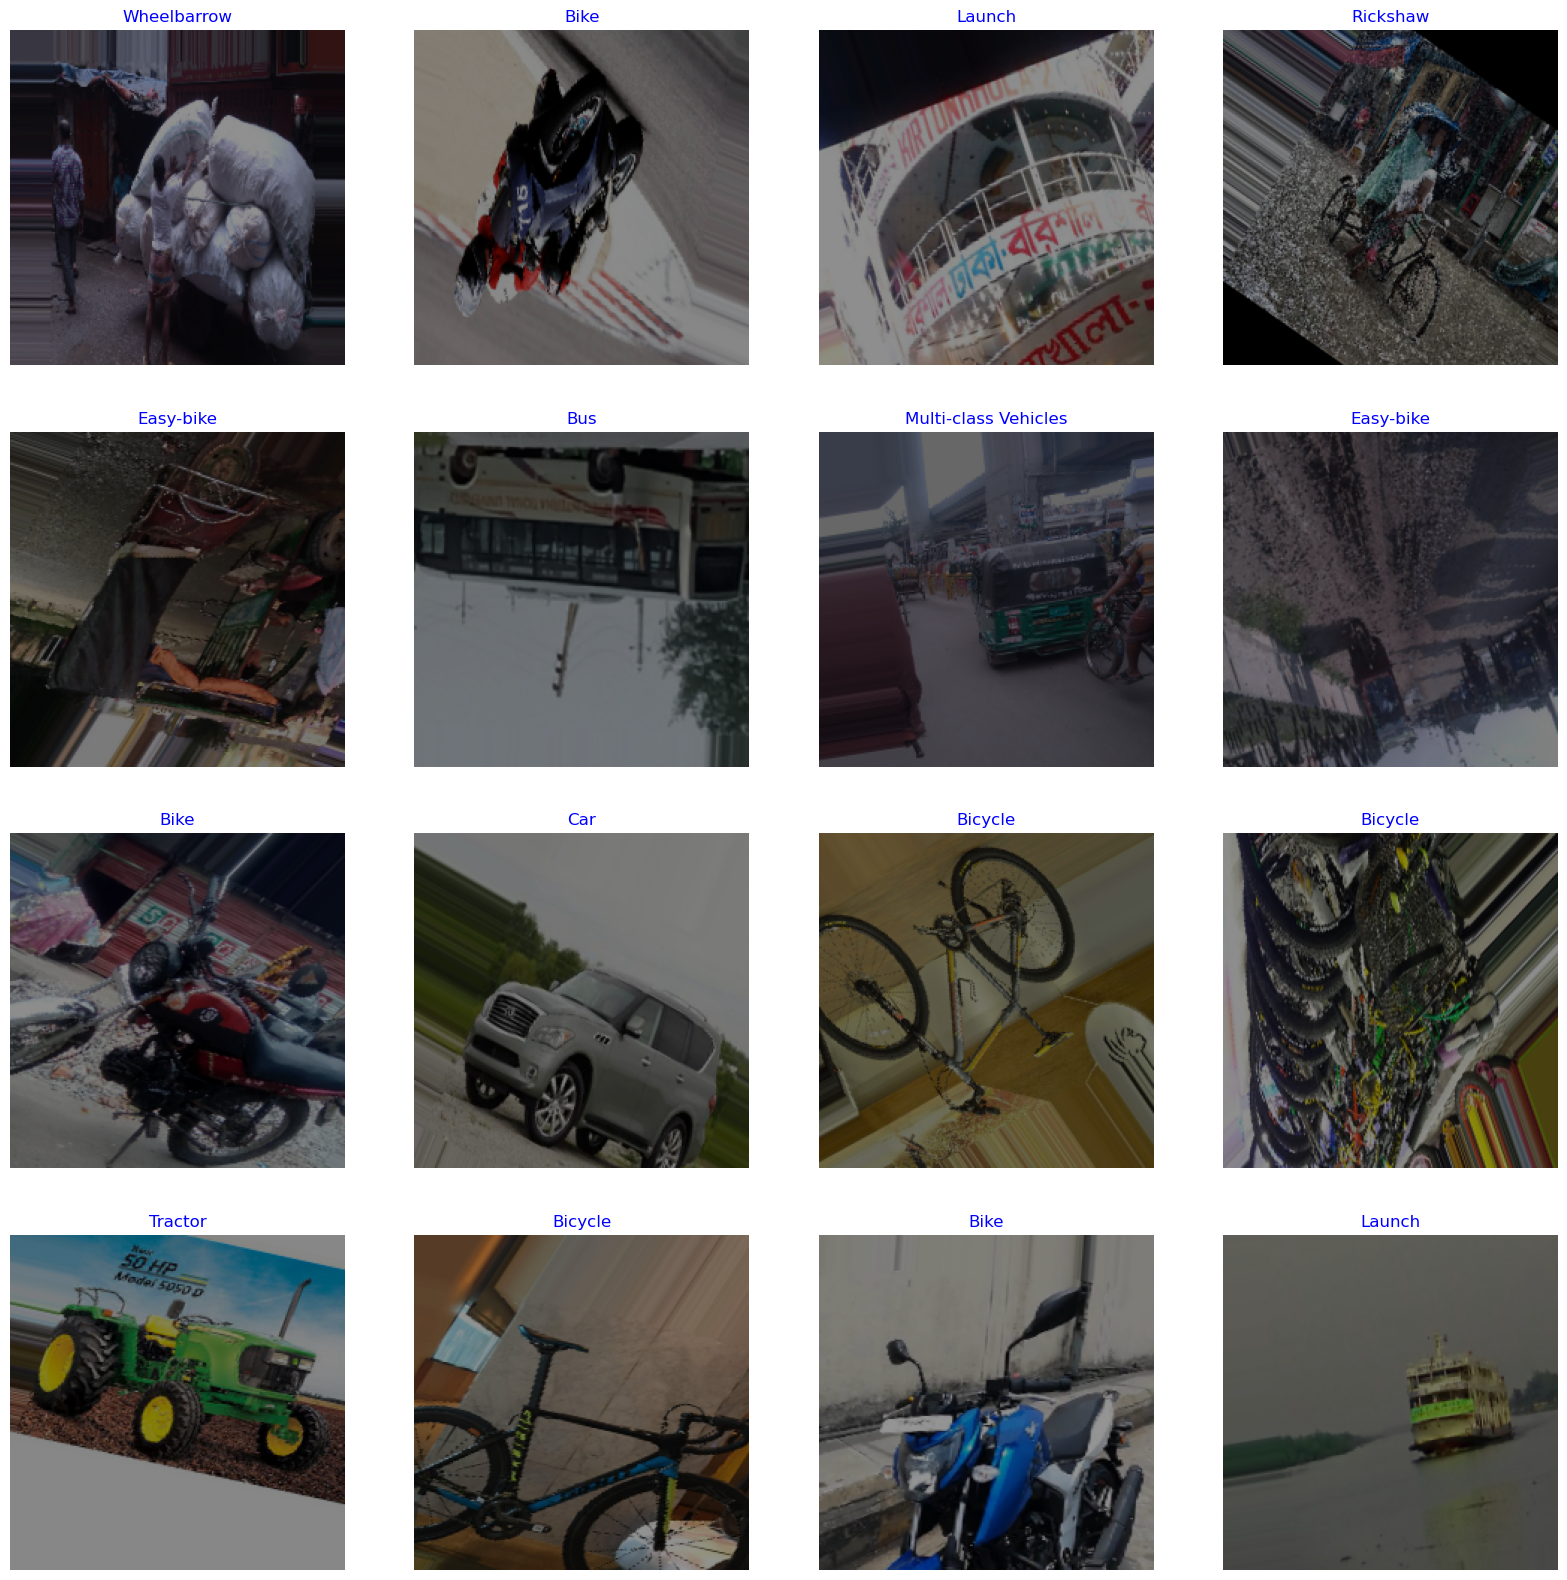

In [30]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
    
plt.show()

In [31]:
# Create Model Structure
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
base_model = tf.keras.applications.efficientnet.EfficientNetB5(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(1024, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.5, seed= 123),
    Dense(class_count, activation= 'softmax')
])

In [32]:
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional)  (None, 2048)             28513527  
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 15)                15375     
                                                                 
Total params: 30,635,270
Trainable params: 2,117,647
Non-trainable params: 28,517,623
__________________________________

In [33]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoint.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [34]:
epochs = 20   
history = model.fit(x=train_gen,
                    epochs= epochs,
                    verbose= 1,
                    validation_data= valid_gen, 
                    validation_steps= None,
                    shuffle= False,
                   callbacks=[model_checkpoint])

Epoch 1/20
204/422 [=============>................] - ETA: 3:40 - loss: 21.2247 - accuracy: 0.5147

C:\Users\SN\Desktop\vehicle-detection-project\env\lib\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


422/422 [==============================] - 491s 1s/step - loss: 17.2314 - accuracy: 0.5760 - val_loss: 10.5405 - val_accuracy: 0.7062
Epoch 2/20
422/422 [==============================] - 474s 1s/step - loss: 7.2479 - accuracy: 0.6777 - val_loss: 4.7568 - val_accuracy: 0.6896
Epoch 3/20
422/422 [==============================] - 478s 1s/step - loss: 3.6166 - accuracy: 0.6894 - val_loss: 2.7299 - val_accuracy: 0.7038
Epoch 4/20
422/422 [==============================] - 475s 1s/step - loss: 2.3928 - accuracy: 0.7009 - val_loss: 2.1155 - val_accuracy: 0.6991
Epoch 5/20
422/422 [==============================] - 486s 1s/step - loss: 2.0037 - accuracy: 0.7004 - val_loss: 1.8831 - val_accuracy: 0.6967
Epoch 6/20
422/422 [==============================] - 473s 1s/step - loss: 1.8581 - accuracy: 0.6998 - val_loss: 1.7344 - val_accuracy: 0.7145
Epoch 7/20
422/422 [==============================] - 474s 1s/step - loss: 1.7545 - accuracy: 0.7094 - val_loss: 1.6889 - val_accuracy: 0.7251
Epoch 8/

In [70]:
#save the model for predictions
# model.save('efficientnet.h5')
# Iterate over the images
for i in range(16):
    try:
        # Load and preprocess the image
        image = images[i] / 255  # scales data to range (0 - 255)

        # Save the image to your model if there is no error
        # Your existing code to save or process the image goes here
        # ...
        model.save('efficientnet.h5')
    except Exception as e:
        print(f"Error processing image {i}: {e}")
        continue


Error processing image 0: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.
Error processing image 1: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.
Error processing image 2: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.
Error processing image 3: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.
Error processing image 4: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.
Error processing image 5: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.
Error processing image 6: Unable to seri

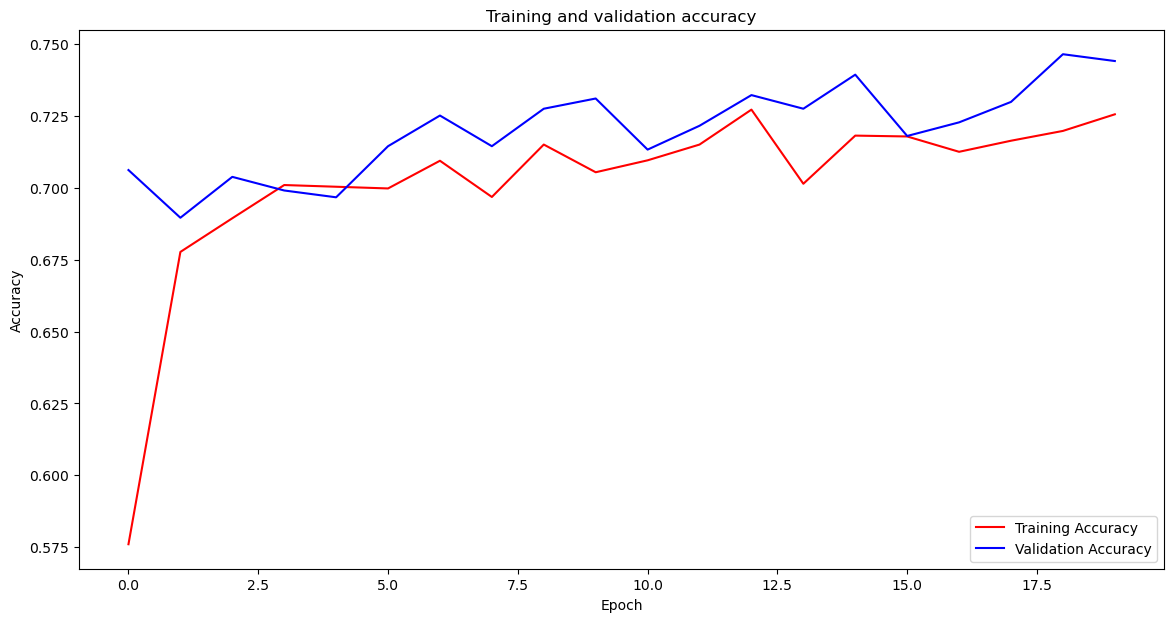

In [45]:
# Validation and Training accuracy plot
import matplotlib.pyplot as plt

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

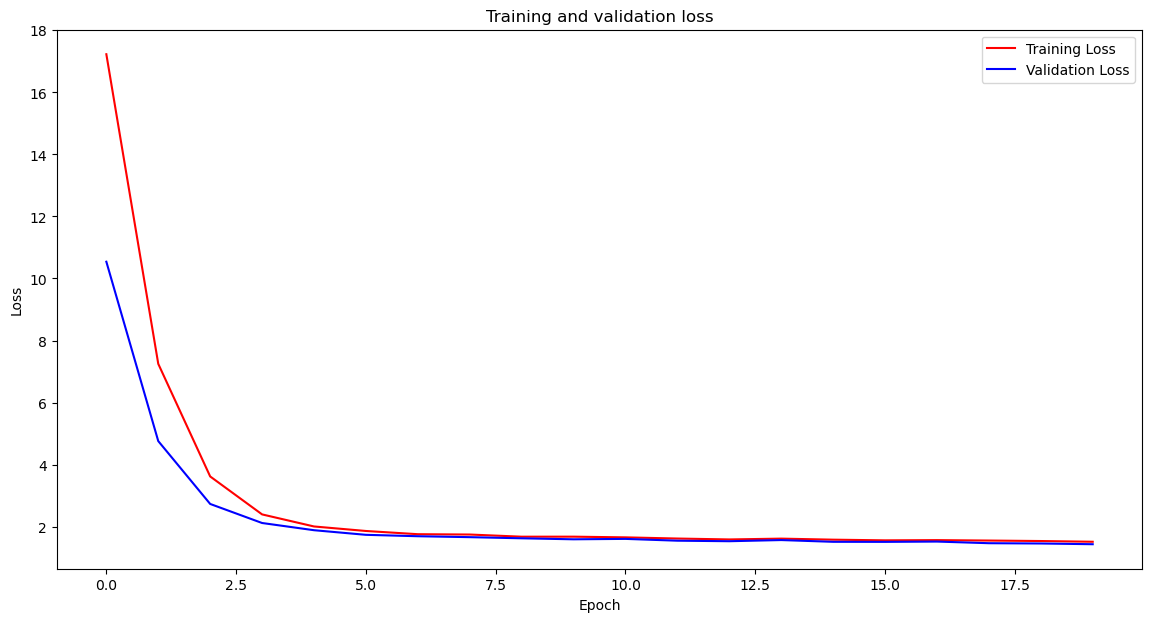

In [46]:
#Validation and Training loss plot
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

# RESNET50

In [47]:
img_shape = (img_size[0], img_size[1], channels)
classifier_resnet = resnet.ResNet50(input_shape= img_shape,include_top=False,weights='imagenet')
for layer in classifier_resnet.layers:
    layer.trainable = False

In [48]:
class_count = len(list(train_gen.class_indices.keys())) 
classifier2 = classifier_resnet.output#head mode
classifier2 = Flatten()(classifier2)#adding layer of flatten
classifier2 = Dropout(0.6)(classifier2)
classifier2 = Dense(units=class_count, activation='softmax')(classifier2)

model2 = Model(inputs = classifier_resnet.input , outputs = classifier2)
model2.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [49]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [50]:
history2 = model2.fit(x=train_gen,
                    epochs= 20,
                    verbose= 1,
                    validation_data= valid_gen, 
                    validation_steps= None,
                    shuffle= False)

Epoch 1/20
422/422 [==============================] - 471s 1s/step - loss: 5.0620 - accuracy: 0.4570 - val_loss: 2.9282 - val_accuracy: 0.5936
Epoch 2/20
422/422 [==============================] - 476s 1s/step - loss: 3.6149 - accuracy: 0.5605 - val_loss: 3.0005 - val_accuracy: 0.6173
Epoch 3/20
422/422 [==============================] - 472s 1s/step - loss: 3.4864 - accuracy: 0.5960 - val_loss: 2.7355 - val_accuracy: 0.6374
Epoch 4/20
422/422 [==============================] - 472s 1s/step - loss: 3.4492 - accuracy: 0.6085 - val_loss: 3.0437 - val_accuracy: 0.5853
Epoch 5/20
422/422 [==============================] - 467s 1s/step - loss: 3.5396 - accuracy: 0.6217 - val_loss: 3.2039 - val_accuracy: 0.6517
Epoch 6/20
422/422 [==============================] - 466s 1s/step - loss: 3.4482 - accuracy: 0.6346 - val_loss: 3.0136 - val_accuracy: 0.6552
Epoch 7/20
422/422 [==============================] - 469s 1s/step - loss: 3.4896 - accuracy: 0.6436 - val_loss: 2.9604 - val_accuracy: 0.6623

In [72]:
model2.save('resnet.h5')
# Save the model weights
model2.save_weights('resnet_weights.h5')


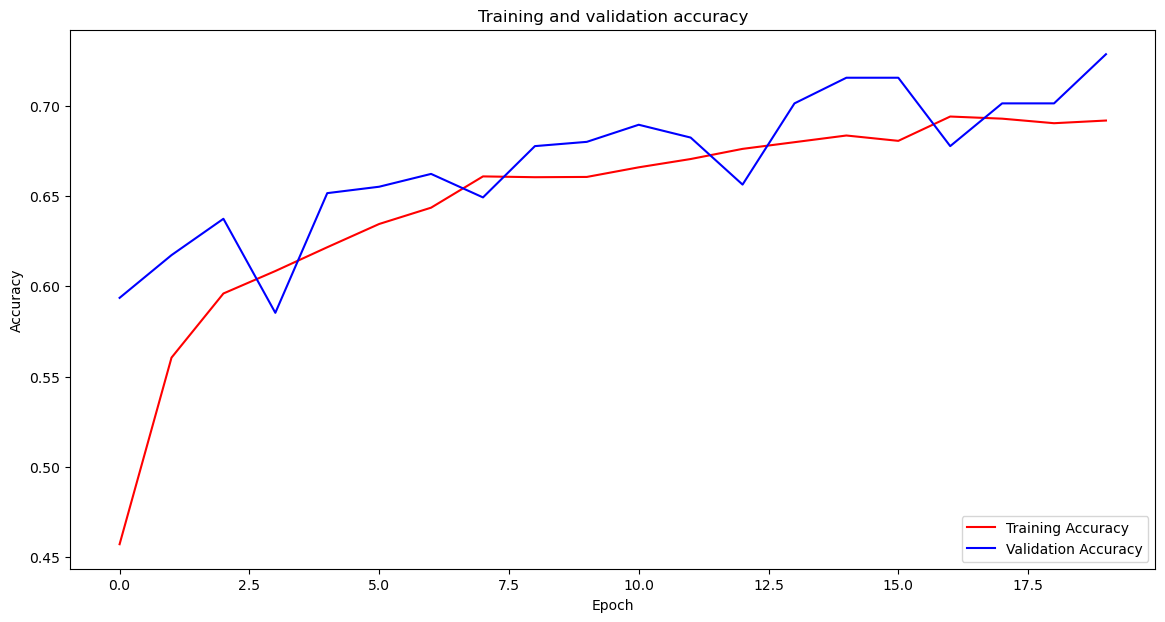

In [55]:
# Validation and Training accuracy plot
acc=history2.history['accuracy']
val_acc=history2.history['val_accuracy']
loss=history2.history['loss']
val_loss=history2.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

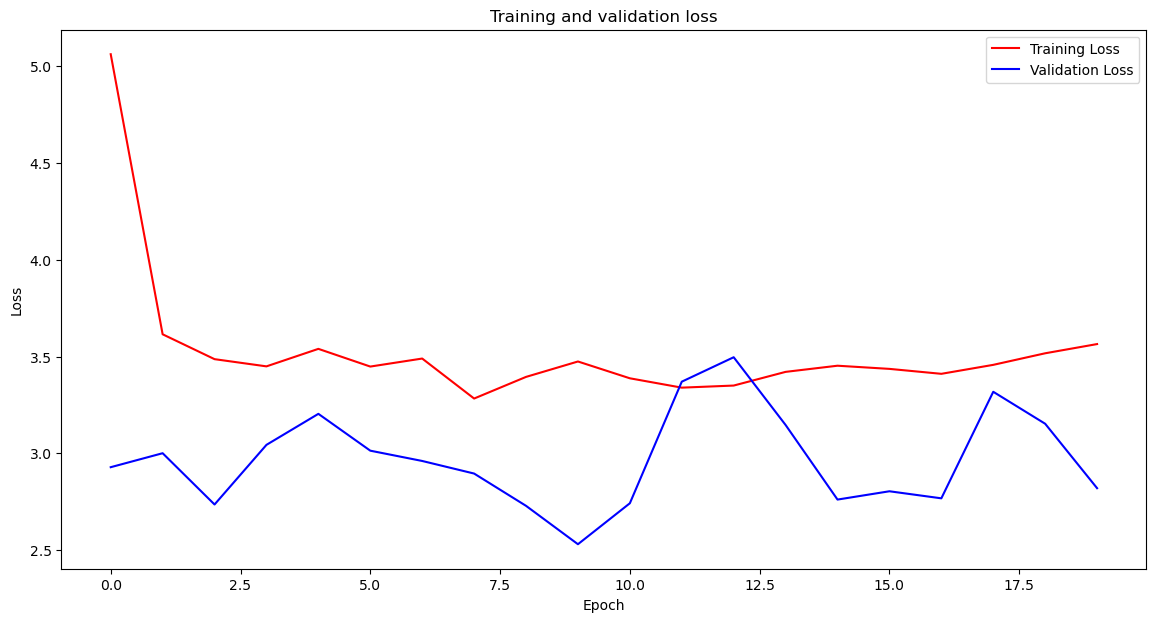

In [56]:
#Validation and Training loss plot
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

# VGG16

In [57]:
img_shape = (img_size[0], img_size[1], channels)
classifier_vgg16 = VGG16(input_shape= img_shape,include_top=False,weights='imagenet')
for layer in classifier_vgg16.layers:
    layer.trainable = False

In [58]:
class_count = len(list(train_gen.class_indices.keys())) 
classifier3 = classifier_vgg16.output#head mode
classifier3 = Flatten()(classifier3)#adding layer of flatten
classifier3 = Dense(units=256, activation='relu')(classifier3)
classifier3 = Dropout(0.6)(classifier3)
classifier3 = Dense(units=class_count, activation='softmax')(classifier3)

model3 = Model(inputs = classifier_vgg16.input , outputs = classifier3)
model3.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [59]:
model3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [60]:
history3 = model3.fit(x=train_gen,
                    epochs= 20,
                    verbose= 1,
                    validation_data= valid_gen, 
                    validation_steps= None,
                    shuffle= False)

Epoch 1/20
422/422 [==============================] - 483s 1s/step - loss: 3.9836 - accuracy: 0.1701 - val_loss: 2.2881 - val_accuracy: 0.3069
Epoch 2/20
422/422 [==============================] - 472s 1s/step - loss: 2.4368 - accuracy: 0.2424 - val_loss: 2.1322 - val_accuracy: 0.3519
Epoch 3/20
422/422 [==============================] - 474s 1s/step - loss: 2.3011 - accuracy: 0.2986 - val_loss: 2.0334 - val_accuracy: 0.3874
Epoch 4/20
422/422 [==============================] - 468s 1s/step - loss: 2.2288 - accuracy: 0.3317 - val_loss: 1.9378 - val_accuracy: 0.4159
Epoch 5/20
422/422 [==============================] - 463s 1s/step - loss: 2.1372 - accuracy: 0.3548 - val_loss: 1.8529 - val_accuracy: 0.4408
Epoch 6/20
422/422 [==============================] - 466s 1s/step - loss: 2.1310 - accuracy: 0.3460 - val_loss: 1.8249 - val_accuracy: 0.4550
Epoch 7/20
422/422 [==============================] - 463s 1s/step - loss: 2.0580 - accuracy: 0.3771 - val_loss: 1.7826 - val_accuracy: 0.4680

In [73]:
model3.save('vgg16.h5')
# Save the model weights
model3.save_weights('vgg16_weights.h5')


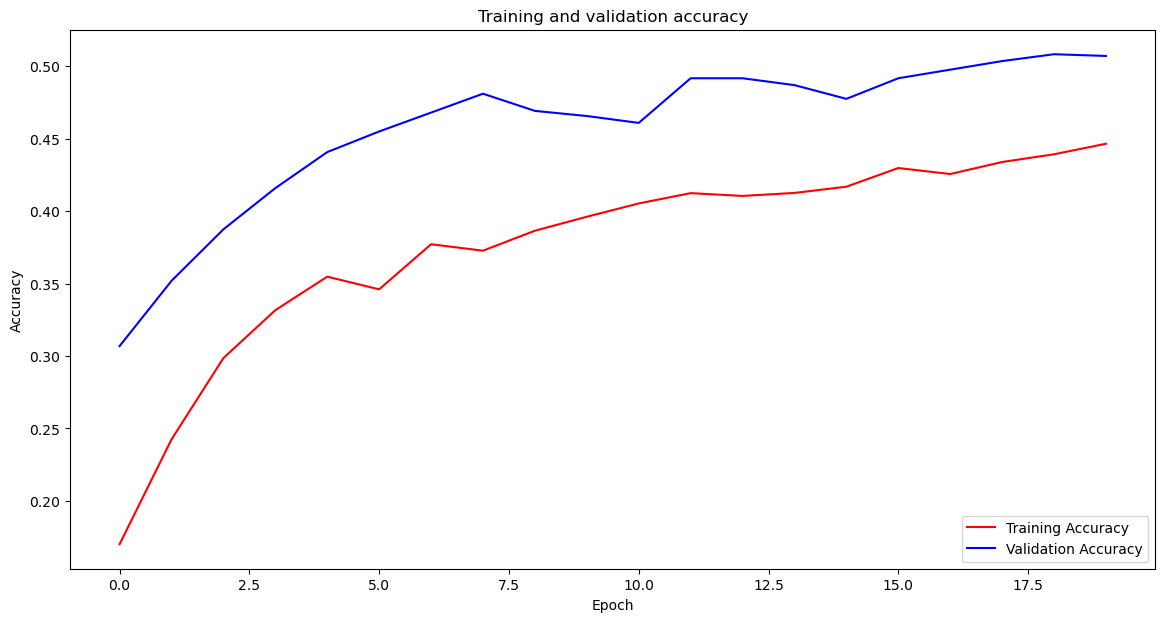

In [62]:
# Validation and Training accuracy plot
acc=history3.history['accuracy']
val_acc=history3.history['val_accuracy']
loss=history3.history['loss']
val_loss=history3.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

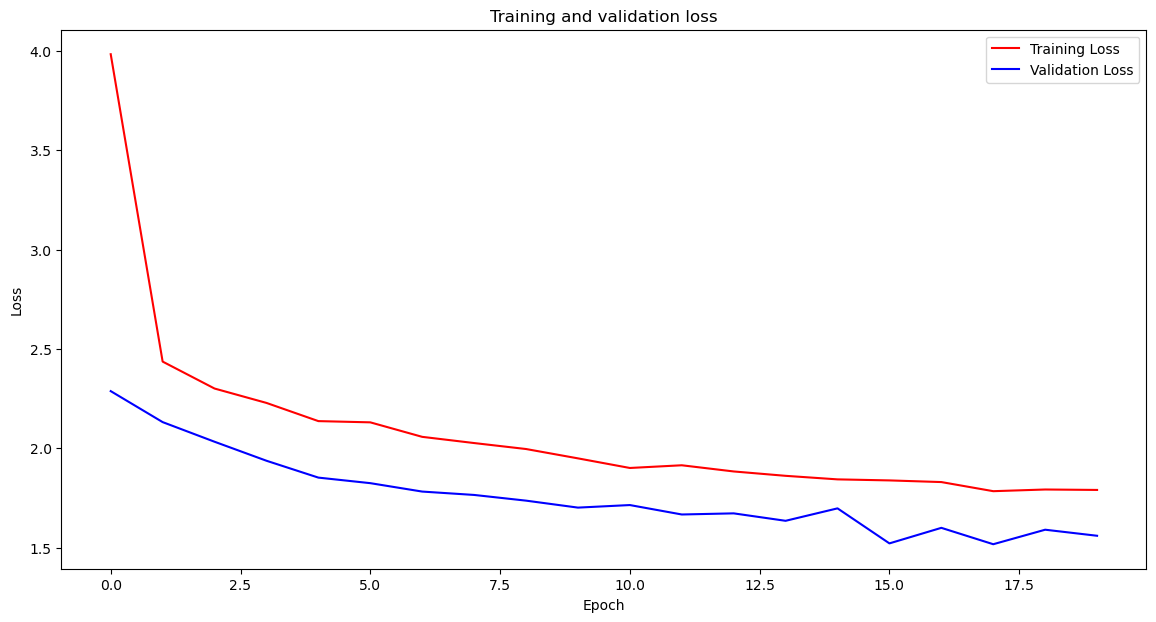

In [63]:
#Validation and Training loss plot
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')